In [41]:
import numpy as np
import tensorflow as tf
from keras import layers
from keras.models import Sequential
from keras.layers import Dropout,LSTM,Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
import datetime

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)
import gc
import math
import pandas as pd
import pickle

In [42]:
# In[4]:


import matplotlib.pyplot as plt
import os
import numpy as np


# ### 计算T矩阵

# In[5]:

In [43]:
def getTmatrixByStation(pairdata,target_station):
    AMap={}
    
    target_pairdata_in=pairdata[pairdata['IN_CODE']==target_station].drop('IN_CODE',axis=1)
    target_pairdata_out=pairdata[pairdata['OUT_CODE']==target_station].drop('OUT_CODE',axis=1)
    
    for name,group in target_pairdata_in['INTERVAL'].groupby(target_pairdata_in['OUT_CODE']):
        AMap[name]=(group.count(),group.sum())
    
    for name,group in target_pairdata_out['INTERVAL'].groupby(target_pairdata_out['IN_CODE']):
        if name in AMap:
            try:
                AMap[name]=(AMap[name][0]+group.count(),AMap[name][1]+group.sum())
            except:
                print(name)
        else:
            AMap[name]=(group.count(),group.sum())
            
    for k,v in AMap.items():
        AMap[k]=AMap[k][1]/(AMap[k][0]*60)

    # if len(list(AMap.keys())) != 122:
    #     undo_stations=getAllStations_by_pkl()
    #     undo_stations.remove(target_station)
    #     for key in list(AMap.keys()):
    #         undo_stations.remove(key)
    #     print(undo_stations)

    map_df=pd.DataFrame({'CODE':list(AMap.keys()),'INTERVAL':list(AMap.values())})
    return map_df.set_index('CODE')

In [44]:
# In[40]:

def fill_tmatrix_122(result,out_station):
    for key in list(result.keys()):
        data_day=result[key]
        if len(data_day.index)!=122:
            stations=list(data_day.index)
            all_stations=getAllStations_by_pkl()
            for station in stations:
                all_stations.remove(station)
            all_stations.remove(out_station)
            for station in all_stations:
                result[key].loc[station]=get_station_by_other_day(station,result)

    return result

    return result

In [45]:
def get_station_by_other_day(station,result):
    station_data=[]
    for key in list(result.keys()):
        data_day = result[key]
        if station in list(data_day.index):
            station_data.append(data_day.loc[station])

    return np.array(station_data).sum()/len(station_data)

In [46]:
def getTMatrix_by_day(data,out_station):
    result={}
    code=getTmatrixByStation(data[data['WEEK']==1],out_station).index
    for i in range(1,8):
        data_day=data[data['WEEK']==i]
        result[str(i)]=getTmatrixByStation(data_day,out_station)

    result=fill_tmatrix_122(result,out_station)
    matrix=[]
    for key in result.keys():
        matrix.append(result[key]['INTERVAL'].tolist())
        
    matrix_T=np.array(matrix).T
    return pd.DataFrame(matrix_T,index=code,columns=['Mon','Tues','Wed','Thur','Fri','Sat','Sun'])


# ### 计算全网进站时序

# In[7]:


def getAllStations(pairdata):
    
    return list(set(pairdata.IN_CODE))


# In[8]:

def getAllStations_by_pkl():
    with open('all_stations.pkl','rb') as f:
        arr=pickle.load(f)

    return arr


def time2seconds(time):
    hours=int(str(time)[:-4])
    minutes=int(str(time)[-4:-2])
    seconds=int(str(time)[-2:])
    
    return hours*60*60+minutes*60+seconds


# In[9]:


def get_in_sequence(row):
    in_date=row['IN_DATE']
    in_time=row['IN_TIME']
    
    day=(in_date-1)%100
    single_sequence=math.floor((time2seconds(in_time)-time2seconds(62000))/(60*10))
    sequence=day*100+single_sequence
    
    return sequence


# In[10]:


def peopleBySequenceStation(pairdata):
    result_map={}
    all_stations=sorted(getAllStations(pairdata))
    if len(all_stations) != 122:
        print('错误！全网进站数据不包含完整的车站')
    
    for station in all_stations:
        pairdataByStation=pairdata[pairdata['IN_CODE']==station]
        station_index=[]
        for seq in range(3000):
            station_index.append(len(pairdataByStation[pairdataByStation['IN_SEQUENCE']==seq]))
        result_map[station]=station_index
            
    before_result_df=pd.DataFrame(list(result_map.items()),columns=['CODE','SEQ'])
    for col in range(3000):
        before_result_df[str(col)]=list(seq[col] for seq in before_result_df.SEQ)
        
    return before_result_df


# In[11]:


def getInSequenceByTargetStation(data,target):
    data_noTargetSta=data[data['IN_CODE']!=target]
    data_noTargetSta['IN_SEQUENCE']=data_noTargetSta.apply(lambda r:get_in_sequence(r),axis=1)
    
    in_seq=peopleBySequenceStation(data_noTargetSta)
    return in_seq.drop('SEQ',axis=1)


# ### 计算以目标站点为出站的全网进站时序

# In[12]:


def getInSeqByTargetStation(data,target):
    data_target_out=data[data['OUT_CODE']==target]
    data_target_out['IN_SEQUENCE']=data_target_out.apply(lambda r:get_in_sequence(r),axis=1)
    
    in_seq_target=peopleBySequenceStation(data_target_out)
    return in_seq_target.drop('SEQ',axis=1).set_index('CODE')


# ### 计算目标站点的出站时序

# In[13]:


def get_out_sequence(row):
    out_date=row['OUT_DATE']
    out_time=row['OUT_TIME']
    
    day=(out_date-1)%100
    single_sequence=math.floor((time2seconds(out_time)-time2seconds(62000))/(60*10))
    sequence=day*100+single_sequence
    
    return sequence


# In[14]:


def peopleBySequence(pairdata):
    AMap={}
    for name,group in pairdata.groupby('OUT_SEQUENCE'):
        AMap[name]=len(group)
    
    for i in range(3000):
        if i not in AMap:
            AMap[i]=0
    
    AMap_sorted={}
    for key in sorted(AMap.keys()):
        AMap_sorted[key]=AMap[key]
    
    peopleBySequence_df=pd.DataFrame(list(AMap_sorted.items()),columns=['OUT_SEQUENCE', 'COUNT'])
    return peopleBySequence_df


# In[15]:


def out_seq_target(data,target):
    data_target_out=data[data['OUT_CODE']==target]
    data_target_out['OUT_SEQUENCE']=data_target_out.apply(lambda r:get_out_sequence(r),axis=1)
    
    out_seq_target=peopleBySequence(data_target_out)
    return out_seq_target.drop('OUT_SEQUENCE',axis=1)


# ### 计算ODC矩阵

# In[16]:


def interval_10(row):
    return round(row['INTERVAL']/10)


# In[17]:


def getWeek(date):
    week=datetime.datetime.strptime(str(date),'%Y%m%d').weekday()
    
    return week+1


# In[18]:


def getSequenceByStation_no0(station_seq):
    return station_seq[station_seq.values!=0].index


# In[19]:


def get_seq_by_day(cols):
    week={}
    for col in cols:
        date=20170901+int(int(col)/100)
        weekday=getWeek(date)
        if str(weekday) not in week.keys():
            week[str(weekday)]=list()
            week[str(weekday)].append(col)
        else:
            week[str(weekday)].append(col)
    return week


# In[20]:


def seqto1day(seq):
    seq_1day=[0 for i in range(100)]
    for index in seq.index:
        seq_1day[int(index)%100]+=seq[index]
        
    return np.array(seq_1day)


# In[21]:


def average_odc_10min(in_seq,in_seq_target):   
    result_matrix={}
    
    for i in range(7):
        result_matrix[str(i+1)]={}

    for station in in_seq_target.index:
        cols_no0=getSequenceByStation_no0(in_seq.loc[station])
        value_whole=in_seq.loc[station][cols_no0]
        value_target=in_seq_target.loc[station][cols_no0]
        odc_seq=value_target/value_whole
        
        week=get_seq_by_day(odc_seq.index)
        for i in range(7):
            weekday=week[str(i+1)]
            odc_seq_day=odc_seq[weekday]
            odc_seq_day_one=seqto1day(odc_seq_day)
            result_matrix[str(i+1)][station]=odc_seq_day_one/int(len(odc_seq_day)/100)
        
    return result_matrix


# ### 计算ODC时序影响流

# In[22]:


def influenceTMatrixByODC(data,Tmatrix,odc_matrix):
    result_seq=[0 for i in range(3000)]
    Tmatrix_10=round(Tmatrix/10)
    for station in data.index:
        station_seq=data.loc[station]
        for seq in range(3000):
            week=getWeek(20170901+int(seq/100))
            T=int(Tmatrix_10.loc[station][week-1])
            ODC=odc_matrix[str(week)][station][seq%100]
            if seq%100+T<=99:
                result_seq[int(seq+T)]+=station_seq[str(seq)]*ODC
                    
    return pd.DataFrame({'COUNT':result_seq})

In [47]:
#获得标签数据
# def get_labels(out_norm,time_step=20):
#     label=out_norm[7*100+1:]
#     train_label=label[:20*100]
#     test_label=label[20*100:]
    
#     train_Y=[]
#     test_Y=[]
    
#     for i in range(len(train_label)-time_step):
#         train_Y.append(train_label[i:i+time_step].tolist())
        
#     for i in range(len(test_label)-time_step):
#         test_Y.append(test_label[i:i+time_step].tolist())
    
#     return np.array(train_Y),np.array(test_Y) 
def get_labels(out_norm,time_step=20):
    label=out_norm[7*100+1:]
    train_label=label[:20*100]
    test_label=label[20*100:]
    
    train_Y=train_label[20:]
    test_Y=test_label[20:]
    
    return np.array(train_Y),np.array(test_Y) 

### block1[早期进站，后期进站]->出站序列
def block1_data(in_norm,time_step=20):
    data1=in_norm[1:-700]
    data1=data1[:,np.newaxis]
    data2=in_norm[7*100+1:]
    data2=data2[:,np.newaxis]
    data=np.append(data1,data2,axis=-1)
    
    train_data=data[:20*100]
    test_data=data[20*100:]
    
    train_X=[]
    test_X=[]
    for i in range(len(train_data)-time_step):
        train_X.append(train_data[i:i+time_step].tolist())
    
    for i in range(len(test_data)-time_step):
        test_X.append(test_data[i:i+time_step].tolist())
        
    return np.array(train_X),np.array(test_X)


### block2[进站，前一刻出站]->出站序列
def block2_data(in_norm,out_norm,time_step=20):
    data1=out_norm[7*100:-1]
    data1=data1[:,np.newaxis]
    data2=in_norm[7*100+1:]
    data2=data2[:,np.newaxis]
    data=np.append(data1,data2,axis=-1)
    
    train_data=data[:20*100]
    test_data=data[20*100:]
    
    train_X=[]
    test_X=[]
    for i in range(len(train_data)-time_step):
        train_X.append(train_data[i:i+time_step].tolist())
    
    for i in range(len(test_data)-time_step):
        test_X.append(test_data[i:i+time_step].tolist())
        
    return np.array(train_X),np.array(test_X)


# ### block3 [早期出站，后期出站]->出站序列
def block3_data(out_norm,time_step=20):
    fore_data=out_norm[1:-7*100]
    fore_data=fore_data[:,np.newaxis]
    last_data=out_norm[700:-1]
    last_data=last_data[:,np.newaxis]
    data=np.append(fore_data,last_data,axis=-1)
    
    train_data=data[:20*100]
    test_data=data[20*100:]
    
    train_X=[]
    test_X=[]
    
    for i in range(len(train_data)-time_step):
        train_X.append(train_data[i:i+time_step].tolist())
    
    for i in range(len(test_data)-time_step):
        test_X.append(test_data[i:i+time_step].tolist())
        
    return np.array(train_X),np.array(test_X)

#单模型：单入站模型数据
def single_data_in(in_norm,time_step=20):
    data=in_norm[7*100+1:]
    data=data[:,np.newaxis]
    
    train_data=data[:20*100]
    test_data=data[20*100:]
    
    train_X=[]
    test_X=[]
    for i in range(len(train_data)-time_step):
        train_X.append(train_data[i:i+time_step].tolist())
    
    for i in range(len(test_data)-time_step):
        test_X.append(test_data[i:i+time_step].tolist())
        
    return np.array(train_X),np.array(test_X)

#单模型：单出站模型数据
def single_data_out(out_norm,time_step=20):
    data=out_norm[7*100:-1]
    data=data[:,np.newaxis]
    
    train_data=data[:20*100]
    test_data=data[20*100:]
    
    train_X=[]
    test_X=[]
    for i in range(len(train_data)-time_step):
        train_X.append(train_data[i:i+time_step].tolist())
    
    for i in range(len(test_data)-time_step):
        test_X.append(test_data[i:i+time_step].tolist())
        
    return np.array(train_X),np.array(test_X)

# ### 残差模型

# In[26]:


def build_model(): 
    block1_input=Input((20,1))
    block2_input=Input((20,1)) #labels(out_norm,time_step=20):
    
    block3_input=Input((20,2))
    block4_input=Input((20,2))
    block5_input=Input((20,2))
    
    #前一刻出站数据->出站数据
    X=Dense(50)(block1_input)   
    X=layers.recurrent.LSTM(100)(X) #1 (?,100)   
    X=layers.Dropout(0.2)(X)
    block1_result=Dense(20)(X) #(?,20)
    
    #进站数据->出站数据
    block1_result_input=layers.core.Reshape((-1,1))(block1_result)
    block2_X=layers.Concatenate(axis=-1)([block2_input,block1_result_input]) #(?,20,2)
    X=Dense(50)(block2_X)
    X=layers.recurrent.LSTM(100)(X) #1 (?,100)
    X=layers.Dropout(0.2)(X)
    block2_result=Dense(20)(X) #(?,20) 
    block2_result=layers.Average()([block2_result,block1_result])
    
    #[早期进站，后期进站]->出站序列
    block2_result_input=layers.core.Reshape((-1,1))(block2_result)
    block3_X=layers.Concatenate(axis=-1)([block2_result_input,block3_input]) #(?,20,3)
    X=Dense(50)(block3_X)   
    X=layers.recurrent.LSTM(100)(X) #1 (?,100)   
    X=layers.Dropout(0.2)(X)
    block3_result=Dense(20)(X) #(?,20)
    block3_result=layers.Average()([block3_result,block2_result])
    
    #[进站，前一刻出站]->出站序列
    block3_result_input=layers.core.Reshape((-1,1))(block3_result) #(?,20,1)
    block4_X=layers.Concatenate(axis=-1)([block4_input,block3_result_input]) #(?,20,3)
    X=Dense(50)(block4_X)
    X=layers.recurrent.LSTM(100)(X) #1 (?,100)
    X=layers.Dropout(0.2)(X)
    block4_result=Dense(20)(X) #(?,20) 
    block4_result=layers.Average()([block4_result,block3_result])
    
    
    #[早期出站，后期出站]->出站序列
    block4_result_input=layers.core.Reshape((-1,1))(block4_result)
    block5_X=layers.Concatenate(axis=-1)([block4_result_input,block5_input]) #(?,20,3)
    X=Dense(50)(block5_X)
    X=layers.recurrent.LSTM(100)(X)
    X=layers.Dropout(0.2)(X)
    block5_result=Dense(20)(X)
    
    final_result=layers.Average()([block5_result,block4_result])
    final_result=Dense(1)(final_result)
    
    model = Model(inputs = [block1_input,block2_input,block3_input,block4_input,block5_input], outputs = final_result)
    model.compile(loss="mean_squared_error", optimizer="rmsprop")
                                                              
    return model

In [48]:
# ### 单LSTM模型
def build_single_model(input_shape=(20,1)):      
    intpu_X=Input(input_shape)
    X=Dense(50)(intpu_X) 
    
    X=layers.recurrent.LSTM(100)(X)
    X=layers.Dropout(0.2)(X)
    X=Dense(20)(X) 
    
    result=Dense(1)(X)
       
    model = Model(inputs = intpu_X, outputs = result)
    model.compile(loss="mean_squared_error", optimizer="rmsprop")
    
    return model

In [49]:
# 加入历史同期的单LSTM模型
def build_single_model_with_sametime(input_shape=(20,2)):      
    intpu_X=Input(input_shape)
    X=Dense(50)(intpu_X) 
    
    X=layers.recurrent.LSTM(100)(X)
    X=layers.Dropout(0.2)(X)
    X=Dense(20)(X) 
    result=Dense(1)(X) 
       
    model = Model(inputs = intpu_X, outputs = result)
    model.compile(loss="mean_squared_error", optimizer="rmsprop")
    
    return model

In [50]:
#RNN模型
def build_single_model_rnn(input_shape=(20,1)):      
    intpu_X=Input(input_shape)
    X=Dense(50)(intpu_X) 
    
    X=layers.SimpleRNN(100)(X)
    X=layers.Dropout(0.2)(X)
    result=Dense(1)(X) 
       
    model = Model(inputs = intpu_X, outputs = result)
    model.compile(loss="mean_squared_error", optimizer="rmsprop")
    
    return model

In [51]:
# ### 画图

# In[28]:


def evaluate(result,labels,target_station,isSingle):
    acc_num=0
    count=0
    for i in range(len(result)):
        if labels[i]>0:
            acc_num+=np.abs(labels[i]-result[i])/labels[i]
            count+=1
    acc=1-(acc_num/count) #准确率百分比
    average = np.average(np.abs(result - labels)) #绝对平均误差
    max = np.max(np.abs(result - labels)) #误差最大值
    RMSE = np.sqrt(np.average((result - labels) ** 2)) #均方根误差
    
    print('误差最大值：', max)
    print('绝对平均误差：', average)
    print('均方根误差：', RMSE)
    print('准确率百分比', acc)
    
    
    plt.figure(figsize=(20,6))
    plt.plot(list(range(len(result))), list(result), color='R')
    plt.plot(list(range(len(labels))), list(labels), color='G')
    if isSingle==1:        
        plt.savefig('img/'+str(target_station)+'_Single_in.jpg')
        with open('out_data/'+str(target_station)+'_Single_in.pkl','wb') as f:
            pickle.dump([max,average,RMSE,acc],f)
    elif isSingle==2:
        plt.savefig('img/'+str(target_station)+'_Single_out.jpg')
        with open('out_data/'+str(target_station)+'_Single_out.pkl','wb') as f:
            pickle.dump([max,average,RMSE,acc],f)
    else:
        plt.savefig('img/'+str(target_station)+'_Resnet.jpg')
        with open('out_data/'+str(target_station)+'_Resnet.pkl','wb') as f:
            pickle.dump([max,average,RMSE,acc],f)
    plt.show()
    
    return max,average,RMSE,acc


# ### 绘制比较图

# In[29]:


def compare_img(target_station,obj0,obj1,obj2):
    x_names=['max_mis','avg_mis','RMSE','acc']
    index=np.arange(4)
    bar_width=0.3
    m1=plt.bar(index-bar_width/2,obj0,bar_width,color='b')
    m2=plt.bar(index+bar_width/2,obj1,bar_width,color='r')
    m3=plt.bar(index+bar_width*1.5,obj2,bar_width,color='g')
    plt.xticks(index, x_names)
    
    # 添加数据标签
    def add_labels(rects):
        for rect in rects:
            height = rect.get_height()
            plt.text(rect.get_x() + rect.get_width() / 2, height, height, ha='center', va='bottom')
            # 柱形图边缘用白色填充，纯粹为了美观
            rect.set_edgecolor('white')
    
    add_labels(m1)
    add_labels(m2)
    add_labels(m3)
    plt.savefig('img/'+str(target_station)+'_compare.jpg')
    plt.show()


# In[35]:

In [52]:
def save_file(path,file):
    with open(path,'wb') as f:
        pickle.dump(file,f)

In [53]:
def load_file(path):
    with open(path,'rb') as f:
        file=pickle.load(f)
    
    return file

In [54]:
def eva(test_X_lstm_out,test_Y,out_list,model):
    sum_rmse=0
    sum_max=0
    sum_mae=0
    for i in range(100):
        result=np.array(flat(model.predict(test_X_lstm_out)))
        labels=test_Y
        sum_rmse+=np.sqrt(np.average((result - labels) ** 2))
        sum_max+=max(result-labels)
        sum_mae+=np.average(np.abs(result - labels))
            
    
    print('rmse:',sum_rmse/100)
    print('max',sum_max/100)
    print('mae',sum_mae/100)
    
    return sum_rmse/100,sum_max/100,sum_mae/100

In [55]:
def eva_resnet(train_X_out,train_X_in,train_X_block1,train_X_block2,train_X_block3,test_Y,out_list,model):
    sum_rmse=0
    sum_max=0
    sum_mae=0
    for i in range(100):
        labels=test_Y
        result=np.array(flat(model.predict([train_X_out,train_X_in,train_X_block1,train_X_block2,train_X_block3])))
        sum_rmse+=np.sqrt(np.average((result - labels) ** 2))
        sum_max+=max(result-labels)
        sum_mae+=np.average(np.abs(result - labels))
            
    
    print('rmse:',sum_rmse/100)
    print('max',sum_max/100)
    print('mae',sum_mae/100)
    
    return sum_rmse/100,sum_max/100,sum_mae/100

In [56]:
def model2(target_station,pairdata):
#     print('-------------正在计算'+str(target_station))
#     TMatrix=getTMatrix_by_day(pairdata,target_station) #获得T矩阵 type: DataFrame
    
#     in_seq=getInSequenceByTargetStation(pairdata,target_station) 
#     in_seq=in_seq.set_index('CODE') #获取全网进站时序 type: DataFrame
    
#     in_seq_target=getInSeqByTargetStation(pairdata,target_station) #获取以目标站点为出站点的全网进站时序
    
#     out_seq=out_seq_target(pairdata,target_station) #计算目标站点的出站时序
    
#     odc_matrix=average_odc_10min(in_seq,in_seq_target) #计算ODC矩阵
    
#     in_seq=influenceTMatrixByODC(in_seq,TMatrix,odc_matrix) #计算odc影响时序流
    
#     out_list=np.array(out_seq['COUNT'].tolist()) 
#     in_list=np.array(in_seq['COUNT'].tolist()) 
#     save_file('alter/'+str(target_station)+'/训练输入序列.pkl',[out_list,in_list])
    print('-------------正在计算'+str(target_station))
    outlist,in_list=load_file('alter/'+str(target_station)+'/训练输入序列.pkl')
    
    #标准化
    out_norm=(out_list-np.mean(out_list))/np.std(out_list)
    in_norm=(in_list-np.mean(in_list))/np.std(in_list)
    
    #标签
    train_Y,test_Y=get_labels(out_norm=out_norm) #shape (1980,)(279,)
    
    train_X_block3,test_X_block3=block3_data(out_norm=out_norm)
    #带历史同期数据的单LSTM
    model=build_single_model_with_sametime()
    model.reset_states()
    model.fit(train_X_block3,train_Y,batch_size=50,nb_epoch=500,validation_split=0.05)    
    rmse1,max1,mae1=eva(test_X_block3,test_Y,model)
    #model.save('alter/'+str(target_station)+'/出站-出站-历史同期模型.h5')
    
#     #单LSTM
#     train_X_lstm_out,test_X_lstm_out=single_data_out(out_norm=out_norm) #shape (1980, 20, 1) (279, 20, 1)
#     model=build_single_model()
#     model.reset_states()
#     model.fit(train_X_lstm_out,train_Y,batch_size=50,nb_epoch=500,validation_split=0.05)
#     rmse2,max2,mae2=eva(test_X_lstm_out,test_Y,out_list,model)
#     model.save('alter/'+str(target_station)+'/出站-出站-lstm模型.h5')

#     #RNN模型
#     train_X_lstm_out,test_X_lstm_out=single_data_out(out_norm=out_norm) #shape (1980, 20, 1) (279, 20, 1)
#     model=build_single_model_rnn()
#     model.reset_states()
#     model.fit(train_X_lstm_out,train_Y,batch_size=50,nb_epoch=500,validation_split=0.05)    
#     rmse3,max3,mae3=eva(test_X_lstm_out,test_Y,out_list,model)
#     model.save('alter/'+str(target_station)+'/出站-出站-rnn模型.h5')
    
#     save_file('alter/'+str(target_station)+'历史周期VS单LSTM.pkl',[[rmse1,max1,mae1],[rmse2,max2,mae2],[rmse3,max3,mae3]])

In [57]:
pairdata=pd.read_csv('../twice/315/pairdata.csv') #获取配对数据

In [28]:
load_file('alter/'+str(318)+'历史周期VS单LSTM.pkl')

[[138.98359069968544, 405.89, 92.00387096774192],
 [109.69340561072778, 460.98, 76.13999999999999],
 [110.24577036859034, 377.73, 80.68405017921147]]

In [58]:
def model_by_station(target_station,pairdata):   
    if os.path.exists('alter/'+str(target_station)+'/训练输入序列.pkl'):
        out_list,in_list=load_file('alter/'+str(target_station)+'/训练输入序列.pkl')
    else:
        TMatrix=getTMatrix_by_day(pairdata,target_station) #获得T矩阵 type: DataFrame
        in_seq=getInSequenceByTargetStation(pairdata,target_station) 
        in_seq=in_seq.set_index('CODE') #获取全网进站时序 type: DataFrame
    
        in_seq_target=getInSeqByTargetStation(pairdata,target_station) #获取以目标站点为出站点的全网进站时序

        out_seq=out_seq_target(pairdata,target_station) #计算目标站点的出站时序

        odc_matrix=average_odc_10min(in_seq,in_seq_target) #计算ODC矩阵

        in_seq=influenceTMatrixByODC(in_seq,TMatrix,odc_matrix) #计算odc影响时序流

        out_list=np.array(out_seq['COUNT'].tolist()) 
        in_list=np.array(in_seq['COUNT'].tolist()) 
        save_file('alter/'+str(target_station)+'/训练输入序列.pkl',[out_list,in_list])
    
    #标准化
    out_norm=(out_list-np.mean(out_list))/np.std(out_list)
    in_norm=(in_list-np.mean(in_list))/np.std(in_list)
    
    #获取数据集
    train_Y,test_Y=get_labels(out_norm=out_norm) #shape (1980,) (279,)
    
    train_X_block1,test_X_block1=block1_data(in_norm=in_norm) 
    train_X_block2,test_X_block2=block2_data(in_norm=in_norm,out_norm=out_norm)
    train_X_block3,test_X_block3=block3_data(out_norm=out_norm)
    train_X_in,test_X_in=single_data_in(in_norm=in_norm)
    train_X_out,test_X_out=single_data_out(out_norm=out_norm)
    print(str(target_station)+'站点')
    
    print('resnet')
    
    #Resnet建模
    model = load_model('alter/'+str(target_station)+'残差模型.h5')
    model.reset_states()
    #model.fit([train_X_out,train_X_in,train_X_block1,train_X_block2,train_X_block3],train_Y,batch_size=50,nb_epoch=500,validation_split=0.05)
    #model.save('alter/'+str(target_station)+'残差模型.h5') 
    
    #测试
    rmse1,max1,mae1=eva_resnet(test_X_out,test_X_in,test_X_block1,test_X_block2,test_X_block3,test_Y,out_list,model)
#     with open('out_data/'+str(target_station)+'_resnet_result.pkl','wb') as f:
#             pickle.dump([result,labels],f)
    
#     max0,avg0,rmse0,acc0=evaluate(result,labels,target_station,0)
    
    print('单出站')
    #单LSTM建模:进站
    model = load_model('alter/'+str(target_station)+'单出站模型.h5')
    model.reset_states()
    #model.fit(train_X_in,train_Y,batch_size=50,nb_epoch=500,validation_split=0.05)
    #model.save('alter/'+str(target_station)+'影响流模型.h5') 
    
    #测试
    rmse2,max2,mae2=eva(test_X_in,test_Y,out_list,model)
#     with open('out_data/'+str(target_station)+'_single_in_result.pkl','wb') as f:
#             pickle.dump([result,labels],f)
    
#     max1,avg1,rmse1,acc1=evaluate(result,labels,target_station,1)
    
    print('影响流')
    #单LSTM建模:出站
    model = load_model('alter/'+str(target_station)+'影响流模型.h5')
    model.reset_states()
    #model.fit(train_X_out,train_Y,batch_size=50,nb_epoch=500,validation_split=0.05)
    #model.save('alter/'+str(target_station)+'单出站模型.h5') 
    
#     #测试
    rmse3,max3,mae3=eva(test_X_out,test_Y,out_list,model)
#     with open('out_data/'+str(target_station)+'_single_out_result.pkl','wb') as f:
#             pickle.dump([result,labels],f)
    
#     max2,avg2,rmse2,acc2=evaluate(result,labels,target_station,2)
    
#     compare_img(target_station,[int(max0*10)/10,int(avg0*10)/10,int(rmse0*10)/10,int(acc0*100*10)/10]
#                 ,[int(max1*10)/10,int(avg1*10)/10,int(rmse1*10)/10,int(acc1*100*10)/10]
#                 ,[int(max2*10)/10,int(avg2*10)/10,int(rmse2*10)/10,int(acc2*100*10)/10])

    #save_file('alter/'+str(target_station)+'评估结果.h5',[[rmse1,max1,mae1],[rmse2,max2,mae2],[rmse3,max3,mae3]])

def final_model(pairdata):
    stations=[102,108,212,315,318,321,322,606,618]
    for station in stations:
        model_by_station(station,pairdata)

In [59]:
def flat(seq):
    start=seq[0].tolist()
    for i in range(1,len(seq)):
        start.append(seq[i][-1])
    
    return start

In [36]:
#318,618,606，212，315

In [60]:
final_model(pairdata)

102站点
resnet
rmse: 0.21336281684395683
max 0.826934139157386
mae 0.1439391628471566
单出站
rmse: 0.267968312355525
max 1.3143848297875607
mae 0.17521116284568078
影响流
rmse: 0.34498041874742436
max 2.311148085654713
mae 0.20622124980090273
108站点
resnet
rmse: 0.30581631620049643
max 1.086351183495827
mae 0.21272218388824565
单出站
rmse: 0.4436664529264989
max 2.25132024230047
mae 0.29593339457938794
影响流
rmse: 0.3864193096713286
max 2.626003640729136
mae 0.2533614486707077
212站点
resnet
rmse: 0.4090337513275313
max 1.2528202749258708
mae 0.2864735641951188
单出站
rmse: 0.49693488948140024
max 1.0730968951787734
mae 0.3592414641977627
影响流
rmse: 0.5675789686217624
max 2.3521280851068216
mae 0.41425568967340665
315站点
resnet
rmse: 0.3667424749552437
max 1.009521614673751
mae 0.2721175209300768
单出站
rmse: 0.5599761423419316
max 2.636911855996069
mae 0.3909656022055524
影响流
rmse: 0.5862035742132605
max 2.1552944631691564
mae 0.4124572699220231
318站点
resnet
rmse: 0.33365118607285277
max 1.0062236863601717
ma

In [40]:
losses=[]
f=open('loss.txt','r')
lines=f.readlines()
f.close()
for line in lines:
    if 'loss' in line:
        losses.append(line.split('-')[2].strip().split(':')[1].strip())

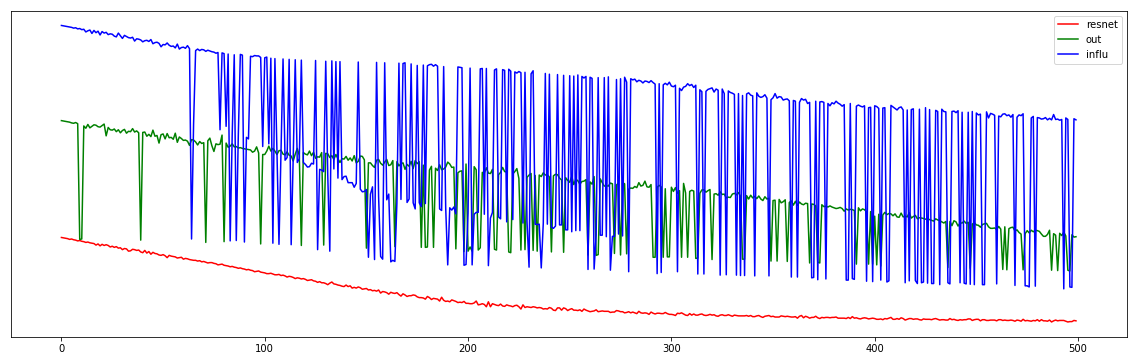

In [59]:
resnet=losses[:500]
out=losses[500:1000]
_in=losses[1000:]

plt.figure(figsize=(20,6)) 
index=list(range(500))
plt.yticks([])
m1=plt.plot(index,resnet,label='resnet',color='r')
m2=plt.plot(index,out,label='out',color='g')
m3=plt.plot(index,_in,label='influ',color='b')
plt.legend()

plt.show()

In [21]:
import redis

In [24]:
# with open('out_data/321_single_out_result.pkl','rb') as f:
#     arr=pickle.load(f)
# result=list(arr[0])
# labels=list(arr[1])
# result.extend(labels)
# conn = redis.Redis(host='127.0.0.1', port=6379)
# for num in result:
#     conn.lpush('321_single_out_out_img',num)

In [34]:
#final_model()

In [ ]:
def predict_out_by_model_by_station(target_station,pairdata):
    if os.path.exists('data/out_seq_'+str(target_station)+'.csv') and os.path.exists('data/in_seq_'+str(target_station)+'.csv'):
        print('原始数据已存在,正在加载...')
    else:
        print('计算原始数据...')
        
        #获得T矩阵
        TMatrix=getTMatrix_by_day(pairdata,target_station)

        #'获取全网进站时序'
        in_seq=getInSequenceByTargetStation(pairdata,target_station)
        in_seq=in_seq.set_index('CODE')
        print('获取全网进站时序计算完成！')

        #获取以目标站点为出站点的全网进站时序
        in_seq_target=getInSeqByTargetStation(pairdata,target_station)

        #计算目标站点的出站时序
        out_seq=out_seq_target(pairdata,target_station)
        out_seq.to_csv('data/out_seq_'+str(target_station)+'.csv')
        print('出站时序计算完成!')

        #计算ODC矩阵
        odc_matrix=average_odc_10min(in_seq,in_seq_target)

        #计算odc影响时序流
        in_seq=influenceTMatrixByODC(in_seq,TMatrix,odc_matrix)
        in_seq.to_csv('data/in_seq_'+str(target_station)+'.csv')
        print('odc影响时序流计算完成!')
        
    #加载数据
    out_seq=pd.read_csv('data/out_seq_'+str(target_station)+'.csv')
    in_seq=pd.read_csv('data/in_seq_'+str(target_station)+'.csv')
    
    #序列化
    out_list=np.array(out_seq['COUNT'].tolist()) 
    in_list=np.array(in_seq['COUNT'].tolist()) 
    
    #标准化
    out_norm=(out_list-np.mean(out_list))/np.std(out_list)
    in_norm=(in_list-np.mean(in_list))/np.std(in_list)
    
    #获取数据集
    train_Y,test_Y=get_labels(out_norm=out_norm)
    train_X_block1,test_X_block1=block1_data(in_norm=in_norm) 
    train_X_block2,test_X_block2=block2_data(in_norm=in_norm,out_norm=out_norm)
    train_X_block3,test_X_block3=block3_data(out_norm=out_norm)
    train_X_in,test_X_in=single_data_in(in_norm=in_norm)
    train_X_out,test_X_out=single_data_out(out_norm=out_norm)
    print(test_X_in.shape)
    print(test_X_out.shape)
    print('获取原始数据集成功!')
    
    #加载已存储的resnet模型
    #model = load_model('model/'+str(target_station)+'_resnet_model.h5')
    model=
    
    #测试
    result=np.array(flat(model.predict([test_X_out,test_X_in,test_X_block1,test_X_block2,test_X_block3])))*np.std(out_list)+np.mean(out_list)
    labels=np.array(flat(test_Y))*np.std(out_list)+np.mean(out_list)
    
    max0,avg0,rmse0,acc0=evaluate(result,labels,target_station,0)

In [ ]:
pairdata=pd.read_csv('../twice/315/pairdata.csv')
predict_out_by_model_by_station(108,pairdata)